# Dispersion Event Search

We measure graduaual $\Delta$Eic in the correct direction when the peak flux is sufficiently high. This is done by defining a function $D(t)$ that is integrated over a window of time. If $\int_{tf}^{ti}D(t) dt > \mathrm{threshold}$ and $D(t) > 0$ for a sufficient fraction of points in the window, the window is accepted as being part of a dispersion event. At the end of the algorithm, overlapping windows are merged together.

Definition of the integrand $D(t)$ is as follows. The change in magnetic latitude is utilized to retain a positive sign when the change is in the correct direction, regardless of whether the satellite is traveling northward/southward or is coming from above/below the event.

Search for:

$\Large{\int_{t_i}^{t_f}{D(t)dt}} > \mathrm{threshold}$

Where..

$\Large{D(t) = \frac{d|\phi|}{dt}a(t)\frac{dEic}{dt}}$

and

$
a(t) =   \left\{
\begin{array}{ll}
      1 & \mathrm{Peak Flux} > \mathrm{threshold} \\
      0 & \mathrm{Otherwise} \\
\end{array} 
\right. 
$

In [33]:
import progressbar
import h5py
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import pytz
import warnings
import pylab as plt
%matplotlib inline
from matplotlib.colors import LogNorm

import search_dispersion_events 
import importlib
importlib.reload(search_dispersion_events)

<module 'search_dispersion_events' from 'C:\\Users\\dedasilv\\OneDrive - NASA\\Desktop\\dmsp_data\\search_dispersion_events.py'>

In [34]:
df = pd.read_csv('data/train.csv', parse_dates=['start_time', 'end_time'])
df.head()

,class,filename,sat,date,start_time,end_time
0,0,data/2015/12/21/dms_20151221_16e.001.hdf5,16,2015-12-21,2015-12-21 09:16:00+00:00,2015-12-21 09:18:00+00:00
1,1,data/2015/12/20/dms_20151220_19e.001.hdf5,19,2015-12-20,2015-12-20 04:05:00+00:00,2015-12-20 04:07:00+00:00
2,0,data/2015/03/17/dms_20150317_18e.001.hdf5,18,2015-03-17,2015-03-17 11:13:00+00:00,2015-03-17 11:18:00+00:00
3,0,data/2011/08/06/dms_20110806_16e.001.hdf5,16,2011-08-06,2011-08-06 11:02:00+00:00,2011-08-06 11:06:00+00:00
4,0,data/2015/12/20/dms_20151220_18e.001.hdf5,18,2015-12-20,2015-12-20 05:56:00+00:00,2015-12-20 05:58:00+00:00


In [95]:

def plot(row):
    importlib.reload(search_dispersion_events)
    
    # Do computation --------------------------------------------------
    fh = search_dispersion_events.read_file(row.filename)

    dEicdt_smooth, Eic = search_dispersion_events.estimate_log_Eic_smooth_derivative(fh, return_Eic=True)

    df_match, integrand = search_dispersion_events.walk_and_integrate(
        fh, dEicdt_smooth, search_dispersion_events.DEFAULT_INTERVAL_LENGTH,
        search_dispersion_events.DEFAULT_MAX_FLUX_THRESHOLD,
        search_dispersion_events.DEFAULT_INTEGRAL_THRESHOLD, 
        search_dispersion_events.DEFAULT_FRAC_ABOVE_ZERO_THRESHOLD,
        return_integrand=True
    )

    # Do plotting --------------------------------------------------
    for _, row_match in df_match.iterrows():
        i = fh['t'].searchsorted(row_match.start_time)
        j = fh['t'].searchsorted(row_match.end_time)

        fig, axes = plt.subplots(2, 1, figsize=(18, 6), sharex=True)

        im = axes[0].pcolor(fh['t'][i:j], np.log10(fh['ch_energy']), fh['ion_d_ener'][:, i:j], 
                            norm=LogNorm(vmin=1e3, vmax=1e8), cmap='jet')
        plt.colorbar(im, ax=axes[0]).set_label('Log Energy Flux')
        plt.colorbar(im, ax=axes[1]).set_label('')

        axes[0].plot(fh['t'][i:j], Eic[i:j], 'b*-')
        axes[0].invert_yaxis()
        axes[0].set_ylabel('Log Energy [eV] - Ions')

        time_length = row_match.end_time - row_match.start_time
        fig.suptitle(f'{time_length.total_seconds() / 60:.1f} minutes : '
                     f'{row_match.start_time.isoformat()} - {row_match.end_time.isoformat()}', fontweight='bold')
        
        title = 'MLAT = (%.1f deg to %.1f deg)' % (fh['mlat'][i], fh['mlat'][j])
        title += ' Northward' if fh['mlat'][j] > fh['mlat'][i] else ' Southward'
        axes[0].set_title(title)

        axes[1].fill_between(fh['t'][i:j], 0, integrand[i:j])
        axes[1].axhline(0, color='black', linestyle='dashed')
        axes[1].set_ylim([-.25, .25])
        axes[1].set_ylabel('D(t) [eV/s]')
        
        if row.start_time > row_match.start_time and row.start_time < row_match.end_time:
            axes[1].axvspan(row_match.start_time, row_match.end_time, color='gray', alpha=0.3)

    return df_match

100% (86399 of 86399) |##################| Elapsed Time: 0:00:07 Time:  0:00:07


,start_time,end_time,integral_min,integral_mean,integral_max,frac_above_zero_min,frac_above_zero_mean,frac_above_zero_max,integrand_min,integrand_mean,integrand_max
0,2015-12-20 00:32:26+00:00,2015-12-20 00:33:55+00:00,0.884571,1.083374,1.223951,0.711864,0.762712,0.813559,-0.033346,0.018452,0.084805
1,2015-12-20 02:15:42+00:00,2015-12-20 02:17:03+00:00,0.702179,0.929786,1.156600,0.711864,0.737288,0.762712,-0.030308,0.015759,0.081809
2,2015-12-20 03:10:15+00:00,2015-12-20 03:11:20+00:00,1.323887,1.363405,1.384687,0.711864,0.728814,0.745763,-0.039375,0.023109,0.099935
3,2015-12-20 03:12:06+00:00,2015-12-20 03:13:06+00:00,0.711937,0.722545,0.733152,0.711864,0.711864,0.711864,-0.118167,0.012247,0.102981
4,2015-12-20 04:04:58+00:00,2015-12-20 04:06:40+00:00,0.724200,0.917530,1.148109,0.745763,0.805085,0.864407,-0.115123,0.015551,0.054498
5,2015-12-20 10:10:12+00:00,2015-12-20 10:11:21+00:00,0.736201,0.842511,0.908559,0.711864,0.728814,0.745763,-0.078755,0.014280,0.093872
6,2015-12-20 14:07:36+00:00,2015-12-20 14:08:49+00:00,0.775547,1.179475,1.323893,0.711864,0.711864,0.711864,-0.130249,0.019991,0.175684
7,2015-12-20 18:35:09+00:00,2015-12-20 18:36:19+00:00,0.735847,0.940447,1.014732,0.711864,0.754237,0.796610,-0.106043,0.015940,0.093959


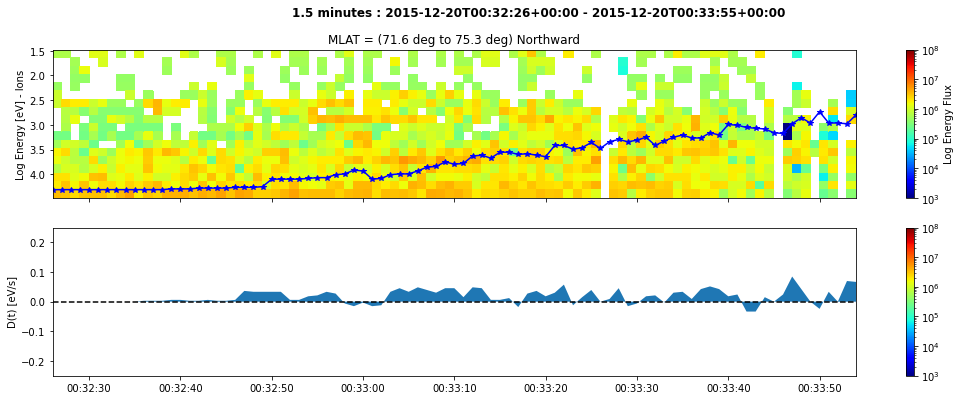

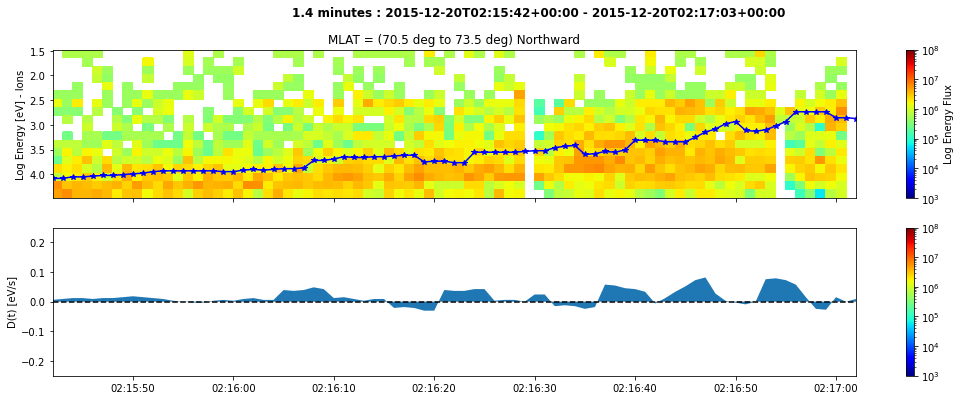

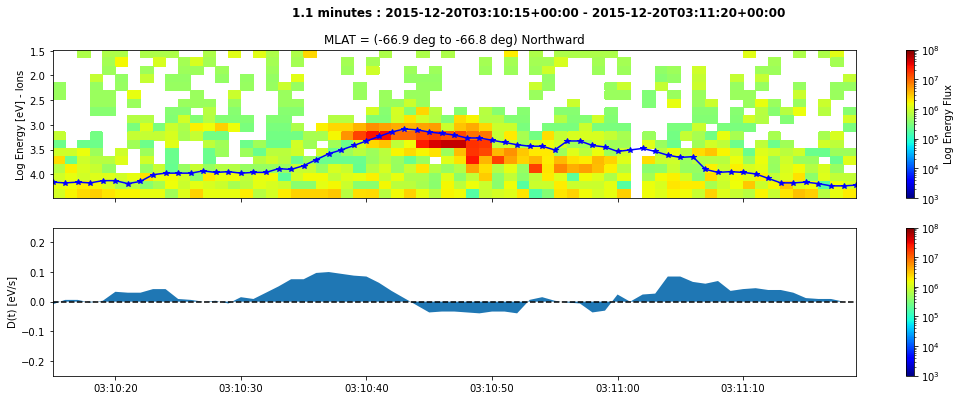

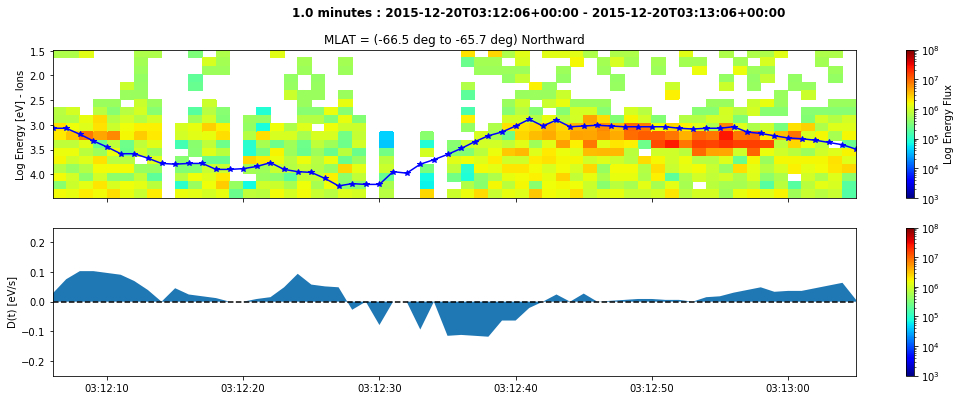

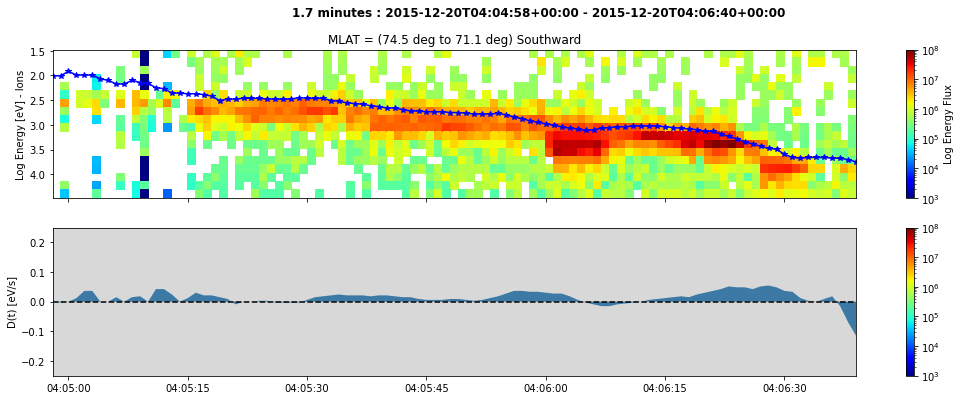

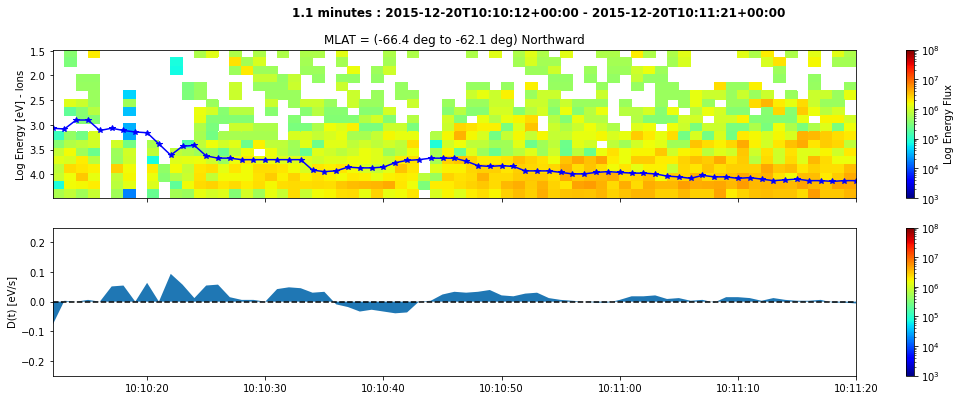

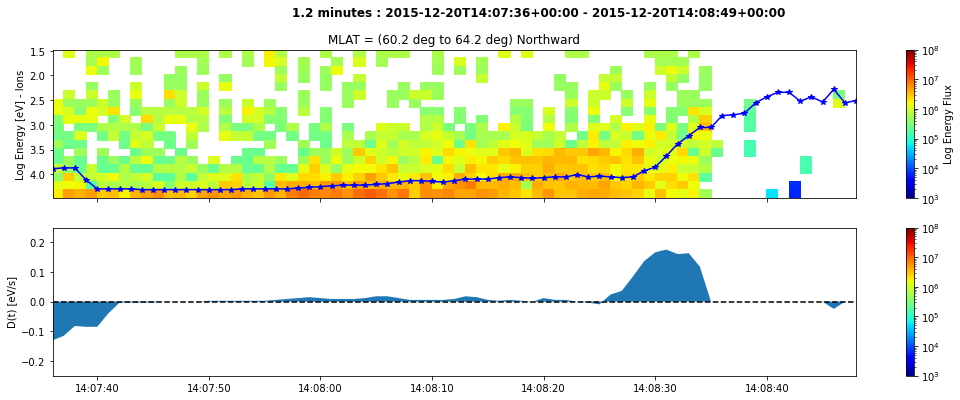

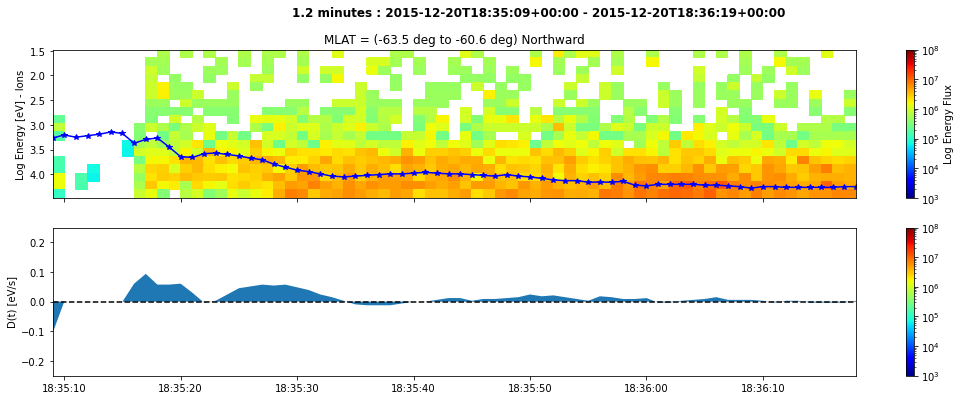

In [98]:
plot(df[df['class'] == 1].iloc[0])